# Bangladesh Rainfall

Bangladesh is located in the tropical region, just off the coast of the Bay of Bengal. The country experiences much rainfall each year and frequent floods.

The purpose of this projet is to try to determine any temporal and spatial patterns in rainfall. The main source of data for this project is from [Daily Total Rainfall Till Jun 2014](http://data.gov.bd/daily-total-rainfall-tilljun-2014) website from the [Bangladesh Open Data](http://data.gov.bd/) website. Since this dataset contained records only upto 2014, I decided to append it with another dataset from [kaggle](https://www.kaggle.com/); this is the [customized daily rainfall data](https://www.kaggle.com/redikod/historical-rainfall-data-in-bangladesh?select=customized_daily_rainfall_data.csv) dataset.

In [ ]:
import sys

if 'geopandas' not in sys.modules:
    !pip install geopandas

import numpy as np
import pandas as pd
import calendar
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline


import requests, zipfile, io, os

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# from rpy2.robjects import pandas2ri
# import rpy2.robjects as ro
# from rpy2.robjects.conversion import localconverter
import rpy2.rinterface
%load_ext rpy2.ipython

#Use -i and -o after %%R rather than %Rpush and %Rget

     |████████████████████████████████| 972kB 5.8MB/s 
     |████████████████████████████████| 6.5MB 38.6MB/s 
     |████████████████████████████████| 14.8MB 314kB/s 


/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
memo = pd.DataFrame()

def cleandf(df, replace_dict= {}, replace_nans =True):
    '''This function takes in a dataframe and:
    removes StationIndex, converts to long format,adds date column
    if initially wide and replaces nan values with 
    average rainfall for that day of year. Removes Feb 29
    
    returns cleaned dataframe'''
    
    def replacenans(tempdf):
        '''This function replaces nan values with average value for that particular month
        This function must be inside the cleandf function because it refers to values defined 
        within the scope of the function.
        
        This takes a row as input and replaces nan values with month average'''
        
        global memo 
        month = tempdf['Month']
        
        #replace nans by mean over the years for a particular day of year and station
#         station = tempdf['Station']
#         dayofyear = tempdf['Date'].dayofyear
#         try:
#             tempdf['Rainfall'] = memo.loc[(station, dayofyear)][0]
#         except:
#             rainfall = df[(df['Station'] == station) & (df['Date'].dt.dayofyear == dayofyear)]['Rainfall'].mean()
#             memo = pd.concat([memo, pd.DataFrame([rainfall], index=[[station],[dayofyear]])])
#             tempdf['Rainfall'] = rainfall
        
        #replace nans by the mean for the month
        try:
            tempdf['Rainfall'] = memo.loc[ month][0]
        except:
            rainfall = df[(df['Month'] == month)]['Rainfall'].mean()
            memo = pd.concat([memo, pd.DataFrame([rainfall], index=[month])])
            tempdf['Rainfall'] = rainfall
        
        return tempdf
    
    def fixstr(row):
        '''Find a function to convert '22 1' and '15' to 22 and 115'''
        
        row = pd.to_numeric(row, errors = 'ignore') #This is needed so that all values that can be numbers are numbers
        temp = pd.to_numeric(row, errors = 'coerce') #This is needed to get the index of misformatted input are read as string by converting to nan 
        indices = np.where(pd.isnull(temp)) #Get the position of nan values and hence index of string
        for index in indices:
            try: #we use try except because misformatted input aren't the only strings
                index = index[0] #index is originall a array so it is converted to number
                x, y = row.iloc[index].split(' ')
                row.iloc[index] = int(x)
                val = int(y + str(row.iloc[index+1])) #we need a dummy variable here because direct assignment does not work
                row.iloc[index+1] = val
            except:
                continue
        return row
    
    #Convert dataframe from wide to long
    if len(df.columns)>30:
        df = df.replace({'\*':2000}, regex=True) #the *** input are replaced by 2000 like a place holder for nan values. This helps the next step in analysis 
        df.iloc[:,3:] = df.iloc[:,3:].apply(fixstr, axis=1)
        df = pd.melt(df,id_vars=['Station','Year','Month'], value_vars=[str(i) for i in range(1,32)], var_name='Day', value_name='Rainfall') 
        
        df['Day'] = pd.to_numeric(df['Day']) #pd.melt change the type to str for both variable and values
        df['Rainfall'] = pd.to_numeric(df['Rainfall'], errors='coerce')
        df['Rainfall'] = df['Rainfall'].replace({2000:np.nan})
    else:
        
        df['Station'] = df['Station'].replace(replace_dict)
        
    
    df = df.drop('StationIndex',axis=1,errors='ignore') #remove stationindex column, if any
    df['Date'] = pd.to_datetime(df[['Year','Month','Day']], errors='coerce') #make a Date column
    # df = df.drop(labels=df[(df['Month']==2) & (df['Day']==29)].index) #remove Feb 29 rows (leap year) (label for drop is df[cond].index)
    df = df[pd.notnull(df['Date'])] # remove rows containing NaT
    
    if replace_nans:
        df.loc[df['Rainfall'].isnull()] = df[df['Rainfall'].isnull()].apply(replacenans,axis=1) # replace nans only in places where nan exists
    else:
        df = df.dropna()

    df['Station'] = df['Station'].str.capitalize().replace({"Cox's bazar": "Cox's Bazar"})
    
    return df



In [ ]:
def mergedfs(df_1, df_2):
    '''Merge the two dataframes with outer merge. The value for rainfall is the one from bd gov data where the value is missing 
    or is in conflict with the data obtained from Kaggle. Otherwise the value is the one from Kaggle. The dataframe is sorted
    based on Year, Station, Month, Day and finally on Date.'''
    
    #assumes 1970 to 2016 dataframe 1st
    
    if df_1['Year'].iloc[0] <df_2['Year'].iloc[0]:
        df_1, df_2 = df_2, df_1
    
    mergedf = df_1.merge(df_2, how='outer', on=['Station', 'Year','Month','Day','Date'],suffixes=['_1970_2016','_1948_2014'])
    
    mergedf = mergedf.sort_values(['Year','Station','Month','Day','Date']).reset_index(drop=True)
    mergedf['Rainfall'] = mergedf[['Rainfall_1948_2014', 'Rainfall_1970_2016']].apply(lambda x: x['Rainfall_1948_2014'] if np.isnan(x['Rainfall_1970_2016'])  
           else (x['Rainfall_1970_2016'] if np.isnan(x['Rainfall_1948_2014']) else x['Rainfall_1948_2014']), axis=1)
    mergedf = mergedf.drop(['Rainfall_1948_2014', 'Rainfall_1970_2016'], axis=1)
    return mergedf

def get_clean_dataframe(replace_nans=True):
    '''Get the final dataframe I will be working with by first importing, then cleaning and finally merging the two dataframes'''
    
    df1, df2 = getdataframes()
    
    if len(df2.columns) > 30:
        df1, df2 = df2, df1
    
    first_set = (set(df2['Station'].unique() )- set( df1['Station'].unique()))
    second_set = (set(df1['Station'].unique() )- set( df2['Station'].unique()))
    rep_dict = dict(zip(first_set, second_set))
    
    df1mod = cleandf(df1, replace_dict = rep_dict, replace_nans=replace_nans)
    df2mod = cleandf(df2, replace_dict = rep_dict, replace_nans=replace_nans)
    
    return mergedfs(df1mod, df2mod)
    

def getdataframes():
    if os.path.exists("/content/sample_data/data-resource_2016_10_18_Daily-Total-Rainfall-Till-Jun-2014.csv"):
        df1 = pd.read_csv('/content/sample_data/data-resource_2016_10_18_Daily-Total-Rainfall-Till-Jun-2014.csv')
    else:
        df1 = pd.read_csv('http://data.gov.bd/api/download/?id=63854365-70d8-4321-9a22-e64411daf97d')
        df1.to_csv('/content/sample_data/data-resource_2016_10_18_Daily-Total-Rainfall-Till-Jun-2014.csv', index=False)
    
    if os.path.exists('/content/sample_data/customized_daily_rainfall_data.csv'):
        df2 = pd.read_csv('/content/sample_data/customized_daily_rainfall_data.csv')
    else:
        try:
            df2= pd.read_csv('https://www.kaggle.com/redikod/historical-rainfall-data-in-bangladesh/download/3WxBSvL8le0vhNLBijAX%2Fversions%2Fu4TkUpu9xVdPKksgXvNh%2Ffiles%2Fcustomized_daily_rainfall_data.csv')
        except:
            from google.colab import drive
            drive.mount('/content/drive')

            df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/customized_daily_rainfall_data.csv')
            df2.to_csv('/content/sample_data/customized_daily_rainfall_data.csv', index=False)
    return df1, df2



In [ ]:
# loc_df.iloc[:,1:]= loc_df.iloc[:,1:].apply(lambda x: pd.to_numeric(x) , axis=1)

https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html

https://towardsdatascience.com/how-to-create-bubble-maps-in-python-with-geospatial-data-e51118c3d767

## Looking at the data
Let us first look at the two datasetes to see how they are formatted, and what preprocessing steps are necessary.

In [ ]:
df1, df2 = getdataframes()
df1.head()

,Station,Year,Month,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,Bogra,1948,1,***,***,***,***,***,***,***,*** *,**,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***
1,Bogra,1948,2,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2,Bogra,1948,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bogra,1948,4,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,41,3,20,0,21,0,0,0,0,0,0,0,0,18,NaN
4,Bogra,1948,5,0,24,0,0,0,0,0,0,2,5,8,0,0,14,0,9,65,0,55,0,21,9,7,24,31,14,0,1,8,0,0


As for the first dataset, we can see that the data is in wide format, so we'll have to transform it into long format for analysis.

There is at least two types of missing values:

1.   Days that are invalid dates (like February 31) are given as NaN.
2.   Records that should have a data but is missing is given as asterisks (***)

There are further issues with the data, like, in some cases data for one column has been included in the previous column, separated by a space. This leads to another type of missing value, where the value is actually missing (no entry).

Another issue with the data is that in, some cases for example the data is given like this:
'100 10' in one column followed by '0' in the next column. In such cases, the trend of the data suggests that the 10 in the first column should be appended to the following column from the left.


In [ ]:
df2.head()

,StationIndex,Station,Year,Month,Day,Rainfall
0,1,Dhaka,1970,1,1,0
1,1,Dhaka,1970,1,2,0
2,1,Dhaka,1970,1,3,0
3,1,Dhaka,1970,1,4,0
4,1,Dhaka,1970,1,5,0


This second dataset is much better formatted, with no missing values. However, as some dates overlap with previous dataset, some care has to be taken to avoid potential conflicts when we merge the dataframes to get final dataframe.



## Exploratory data analysis
Here we get the final dataframe and look for any trends in the data.



In [ ]:
finaldf = get_clean_dataframe(replace_nans=False)
finaldf.head()

Mounted at /content/drive


,Station,Year,Month,Day,Date,Rainfall
0,Bogra,1948,2,1,1948-02-01,0.0
1,Bogra,1948,2,2,1948-02-02,0.0
2,Bogra,1948,2,3,1948-02-03,0.0
3,Bogra,1948,2,4,1948-02-04,4.0
4,Bogra,1948,2,5,1948-02-05,1.0


In [ ]:
# np.nansum(gdf['ADM4_EN'].str.endswith('Court'))

0

In [ ]:
loc_df['Station'].unique()

array(['Barisal', 'Bhola', 'Bogra', 'Borhanuddin', 'Chandpur',
       'Chillimpur', 'Chittagong', 'Chittagong (cv/mil)',
       'Chittagong/ambagan', 'Comilla', 'Cox`s bazar', 'Dacca/tezgaon',
       'Dhaka/tejgaon (mil)', 'Dinajpur', 'Faridpur', 'Farodpur', 'Feni',
       'Hatia', 'Ishurdi', 'Jamalpur', 'Jessore (civ/mil)', 'Khepupara',
       'Khulna', 'Kurmitola/zia intl', 'Lalmonirhat', 'Madaripur',
       'Mymensingn', 'Rajshahi', 'Rangamati', 'Rangpur', 'Saidpur',
       'Sandvip', 'Satkhira', 'Sirajganj', 'Sitakundu', 'Srimangal',
       'Sylhet', 'Sylhet osmani', 'Tangail', 'Teknaf', 'Thakurgaon'],
      dtype=object)

In [ ]:
# sns.displot(finaldf, x='Rainfall',  )

### Rainfall vs Month
From the following figure we can see that months at the beginning and end of the year have very little rainfall, whereas, during the middle of the year. The amount of rainfall peaks in the months of June and July.

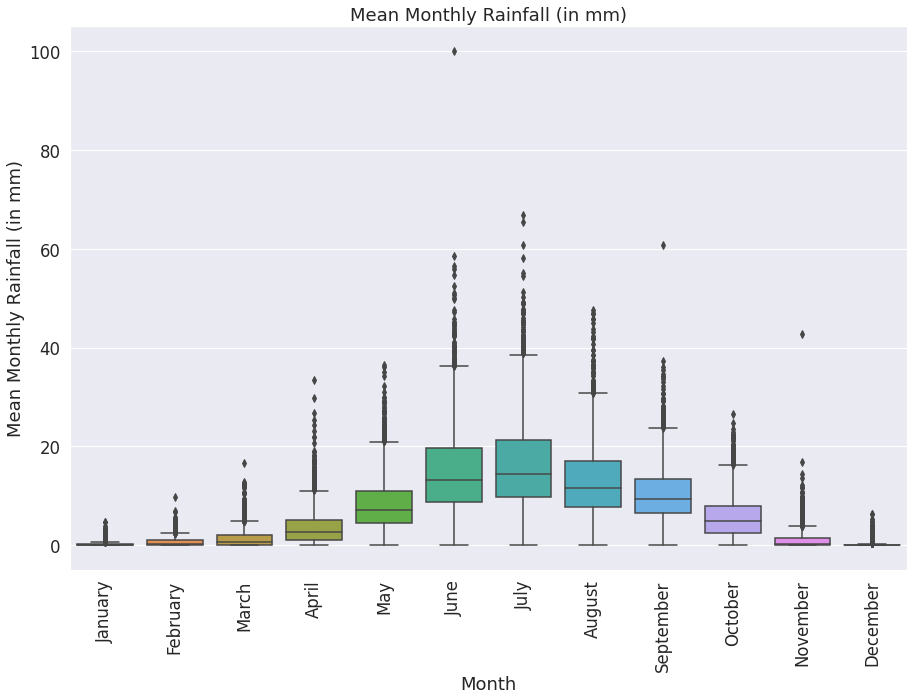

In [ ]:


plt.figure(figsize=(15,10) )
sns.set_theme(font_scale=1.5)

ax= sns.boxplot(x='Month', y='Rainfall', data=finaldf.groupby(['Station','Month','Year'])['Rainfall'].mean().reset_index())
plt.xticks([i-1 for i in finaldf['Month'].unique()],[calendar.month_name[i] for i in finaldf['Month'].unique()] ,rotation=90)
ax.set_title('Mean Monthly Rainfall (in mm)')
ax.set_ylabel('Mean Monthly Rainfall (in mm)')
sns.set_theme(font_scale=1)



### Rainfall by Station 

We can see from the figure that the amount of rainfall varies widely depending on the statoion it is measured at. The highest rainfall is observed at the Teknaf, and Sylhet both which are located in the North Eastern part of the country; And the ones following it: Cox's Bazar and Sandwip are located in the South Eastern part of the country.

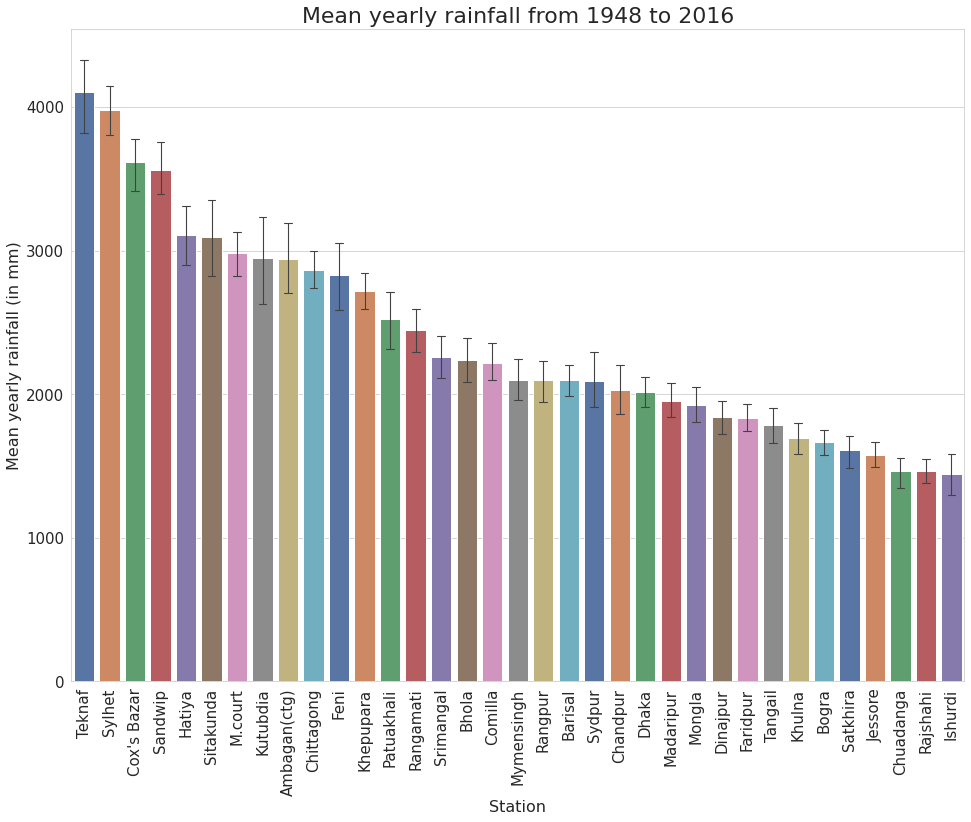

In [ ]:
stationdf = finaldf.groupby(['Station','Year'])['Rainfall'].sum()
stationdf.reset_index()
stationdfmod= stationdf.unstack().mean(axis=1).sort_values(ascending = False)

sns.set_style("whitegrid")

plt.figure(figsize=[16,12])
ax = sns.barplot(x='Station', y='Rainfall' , data= stationdf.reset_index(), order = stationdfmod.index,palette='deep', capsize=0.3 ,errwidth=1.1)  
# ax.set_frame_on(True)
# sns.set_context("talk")

plt.xticks(fontsize=15, rotation=90);
plt.yticks(fontsize=15);
ax.set_title('Mean yearly rainfall from 1948 to 2016',fontsize=22);
ax.set_xlabel("Station", fontsize=16);
ax.set_ylabel("Mean yearly rainfall (in mm)", fontsize=16);
# plt.savefig('Assignment4_figure.png')

It would be better to use a choropleth map to visualize the spatial changes in Rainfall. This is what I try to do next. I will also use a geobubble map. The shape files for Bangladesh is obtained from the site [Bangladesh - Subnational Administrative Boundaries by OCHA](https://data.humdata.org/dataset/administrative-boundaries-of-bangladesh-as-of-2015). The location of Weather statons in Bangladesh has been taken form the site of [Tageo]('http://www.tageo.com/index-e-bg-weather-bg.htm).

In [ ]:
dfs = pd.read_html('http://www.tageo.com/index-e-bg-weather-bg.htm')
dfs

[                                                   0   ...  17
 0   (adsbygoogle = window.adsbygoogle || []).push(...  ... NaN
 1   WorldWide Index  25 Dec 2020  HomeSearchExplor...  ... NaN
 2                                                 NaN  ... NaN
 3                                                 NaN  ... NaN
 4                        WorldWide Index  25 Dec 2020  ... NaN
 ..                                                ...  ...  ..
 71                                             Teknaf  ... NaN
 72                                         Thakurgaon  ... NaN
 73  <!-- \tgoogle_ad_client = "pub-189875598335231...  ... NaN
 74  | Contact us | Tageo.com GPS city index & sate...  ... NaN
 75  | Contact us | Tageo.com GPS city index & sate...  ... NaN
 
 [76 rows x 18 columns],
                                                    0            1   ...   16  17
 0   WorldWide Index  25 Dec 2020  HomeSearchExplor...          NaN  ...  NaN NaN
 1                                       

In [ ]:
loc_df = dfs[-2]
loc_df.columns = loc_df.iloc[0,:]
loc_df = loc_df.drop(index=0).reset_index(drop=True)
loc_df.iloc[:,1:] = loc_df.iloc[:,1:].apply(lambda x: pd.to_numeric(x) , axis=1)
loc_df.iloc[:,2:] = loc_df.iloc[:,2:]/1000
loc_df

,Station,Elevation,Latitude (DD),Longitude (DD)
0,Barisal,40,22.717,90.367
1,Bhola,50,22.683,90.65
2,Bogra,200,24.85,89.367
3,Borhanuddin,80,22.483,90.717
4,Chandpur,70,23.267,90.7
5,Chillimpur,90,22.417,91.75
6,Chittagong,260,22.35,91.817
7,Chittagong (cv/mil),60,22.267,91.817
8,Chittagong/ambagan,340,22.35,91.817
9,Comilla,90,23.433,91.183


In [ ]:
replace_dict ={ 'Chittagong (cv/mil)':'Chittagong','Chittagong':'Ambagan(ctg) at lower elevation)','Chittagong/ambagan':'Ambagan(ctg)', 'Cox`s bazar':"Cox's Bazar",'Dhaka/tejgaon (mil)':'Dhaka',
 'Hatia':'Hatiya','Jessore (civ/mil)':'Jessore','Mymensingn': 'Mymensingh','Sandvip':'Sandwip','Sitakundu':'Sitakunda',
 'Saidpur':'Sydpur'}
loc_df['Station'] = loc_df['Station'].replace(replace_dict)
loc_df

,Station,Elevation,Latitude (DD),Longitude (DD)
0,Barisal,40,22.717,90.367
1,Bhola,50,22.683,90.65
2,Bogra,200,24.85,89.367
3,Borhanuddin,80,22.483,90.717
4,Chandpur,70,23.267,90.7
5,Chillimpur,90,22.417,91.75
6,Ambagan(ctg) at lower elevation),260,22.35,91.817
7,Chittagong,60,22.267,91.817
8,Ambagan(ctg),340,22.35,91.817
9,Comilla,90,23.433,91.183


In [ ]:
station_means = stationdfmod.reset_index()
station_means.columns=['Station', 'Mean annual rainfall']
station_means_loc = station_means.merge(loc_df, on='Station')
station_means_loc.sort_values('Latitude (DD)')

,Station,Mean annual rainfall,Elevation,Latitude (DD),Longitude (DD)
0,Teknaf,4103.650000,60,20.417,92.3
2,Cox's Bazar,3619.652174,40,21.433,91.967
9,Khepupara,2716.790698,90,21.983,90.233
7,Chittagong,2867.796875,60,22.267,91.817
6,Ambagan(ctg),2944.111111,340,22.35,91.817
4,Hatiya,3109.577778,40,22.433,91.1
3,Sandwip,3561.877551,60,22.483,91.417
5,Sitakunda,3097.975000,0,22.583,91.7
10,Rangamati,2448.844828,620,22.633,92.2
12,Bhola,2241.470588,50,22.683,90.65


In [ ]:
station_means_loc['Mean annual rainfall(mean)'] = station_means_loc['Mean annual rainfall']/station_means_loc.shape[0]

gdf2 = gpd.GeoDataFrame(
    station_means_loc, geometry=gpd.points_from_xy(station_means_loc['Longitude (DD)'], station_means_loc['Latitude (DD)']))

In [ ]:

if not os.path.exists("/content/sample_data/bgd_adm_bbs_20201113_SHP/"):
    r = requests.get('https://data.humdata.org/dataset/401d3fae-4262-48c9-891f-461fd776d49b/resource/08736818-ae72-44a9-abd6-a51915c24921/download/bgd_adm_bbs_20201113_shp.zip')
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("/content/sample_data/")

# file = os.listdir("/content/sample_data/bgd_adm_bbs_20201113_SHP/")
# path = [os.path.join("/content/sample_data/bgd_adm_bbs_20201113_SHP/", i) for i in file if i.endswith(".shp")]

# gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in path], 
#                         ignore_index=True), crs=gpd.read_file(path[0]).crs)

gdf = gpd.read_file('/content/sample_data/bgd_adm_bbs_20201113_SHP/bgd_admbnda_adm2_bbs_20201113.shp')

In [ ]:
merged = gdf.merge(station_means, how='left', left_on="ADM2_EN", right_on="Station")
merged = merged[['Station', 'geometry','Mean annual rainfall','ADM2_EN']]
merged.head()

,Station,geometry,Mean annual rainfall,ADM2_EN
0,NaN,"MULTIPOLYGON (((89.84021 21.82784, 89.84052 21...",NaN,Bagerhat
1,NaN,"POLYGON ((92.38065 22.33064, 92.38159 22.33002...",NaN,Bandarban
2,NaN,"MULTIPOLYGON (((89.87968 22.07869, 89.87865 22...",NaN,Barguna
3,Barisal,"MULTIPOLYGON (((90.55429 22.59271, 90.55435 22...",2095.409091,Barisal
4,Bhola,"MULTIPOLYGON (((90.77172 21.85595, 90.76920 21...",2241.470588,Bhola


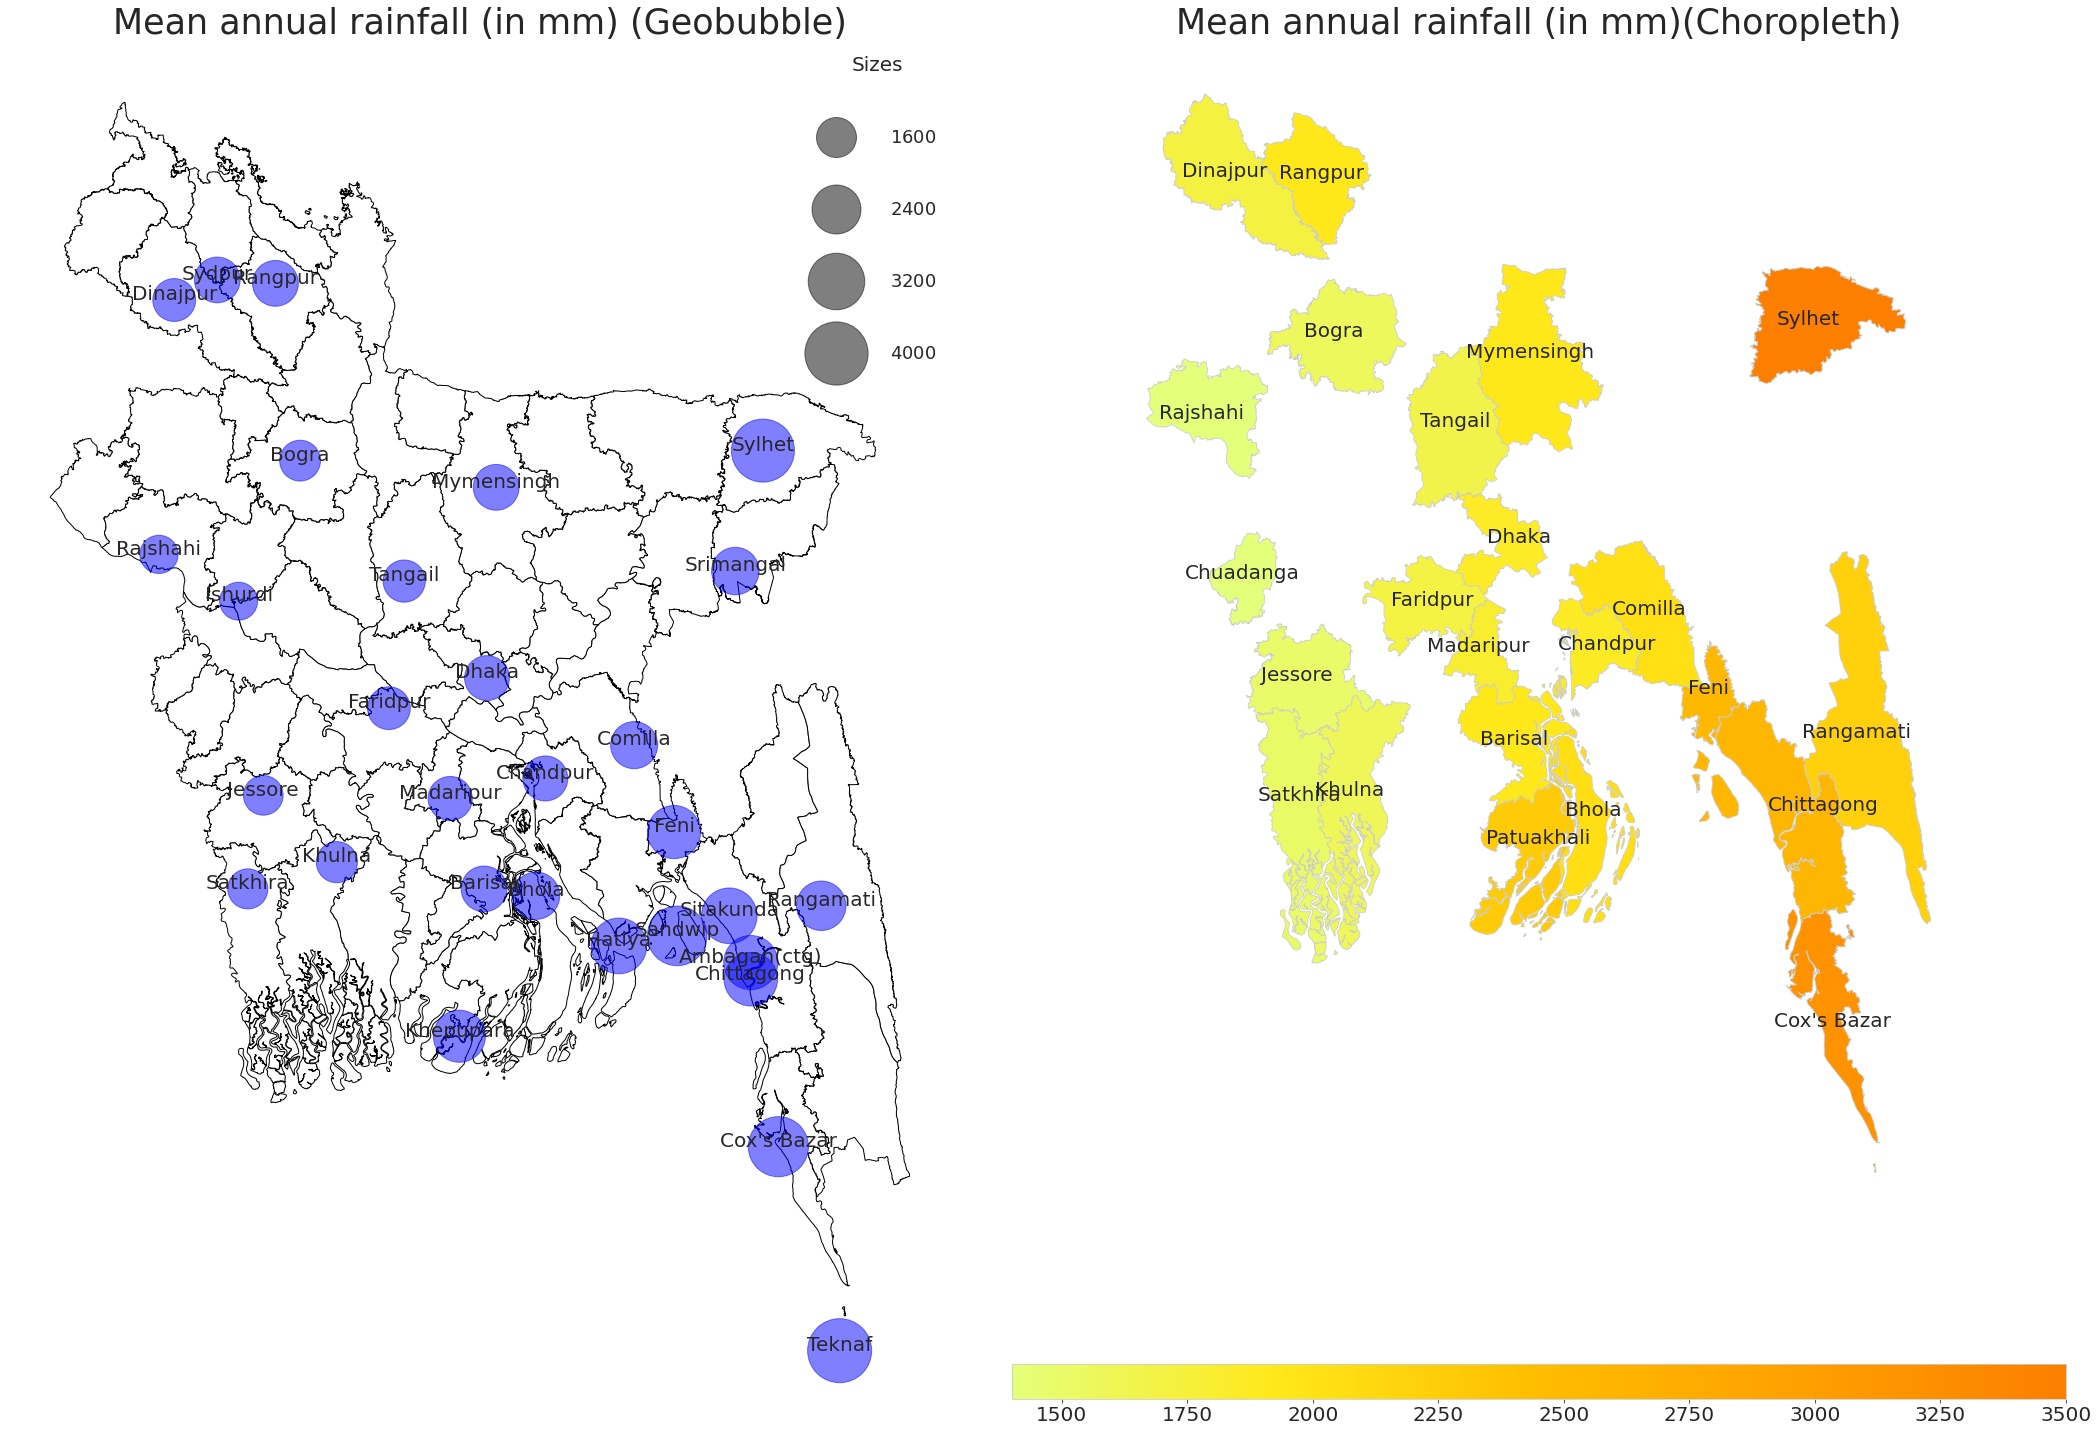

In [38]:
# set the value column that will be visualised
variable = 'Mean annual rainfall'
# set the range for the choropleth values
vmin, vmax = 1400, 3500
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1,2, figsize=(30, 20))


gdf.plot(ax= ax[0], color='white', edgecolor='black');
# gdf2.plot(ax= ax[0],color='blue', markersize='Mean annual rainfall',alpha=0.5, categorical=False, legend=True)
# gdf2.plot(ax= ax[0],color='blue', markersize='Mean annual rainfall', column=gdf2['Mean annual rainfall'],alpha=0.5, legend=True,)

scat = ax[0].scatter(station_means_loc['Longitude (DD)'], station_means_loc['Latitude (DD)'],
                     s=station_means_loc['Mean annual rainfall'], color="blue", alpha=0.5);

ax[0].set_title('Mean annual rainfall (in mm) (Geobubble)', fontdict={'fontsize': '35', 'fontweight' : '4'})

# Add Labels
gdf2['coords'] = gdf2['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf2['coords'] = [coords[0] for coords in gdf2['coords']]
for idx, row in gdf2[gdf2['Station'].notnull()].iterrows():
    ax[0].annotate(s=row['Station'], xy=row['coords'],horizontalalignment='center',fontsize=20)

# sc = plt.scatter(x, y, s=a2, alpha=0.5)
# plt.legend(*tmp.legend_elements("sizes", num=6))

# produce a legend with a cross section of sizes from the scatter
handles, labels = scat.legend_elements(prop="sizes", alpha=0.5, num=4);
legend2 = ax[0].legend(handles, labels, loc="best", title="Sizes",labelspacing=3, fontsize=18, title_fontsize=20, facecolor='blue',frameon=False,handletextpad=2)


# plt.legend()

ax[0].axis('off')

# remove the axis
ax[1].axis('off')
# add a title and annotation
ax[1].set_title('Mean annual rainfall (in mm)(Choropleth)', fontdict={'fontsize': '35', 'fontweight' : '4'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
# Create colorbar legend
# sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm = plt.cm.ScalarMappable(cmap='Wistia', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
# fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
cbar = fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
# create map
merged.plot(column=variable, cmap='Wistia', linewidth=0.8, ax=ax[1], edgecolor='0.8')
cbar.ax.tick_params(labelsize=20) 


# Add Labels
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
for idx, row in merged[merged['Station'].notnull()].iterrows():
    ax[1].annotate(s=row['ADM2_EN'], xy=row['coords'],horizontalalignment='center',fontsize=20)
plt.tight_layout()


The choropleth map above shows clearly that the Eastern side of Bangladesh experiences much more rainfall than the West. Some locations appear to be missing from the choropleth map because the locations of the stations don't map neatly onto a district.

### Rainfall by Year
The frequency of floods is increasing over the years, so I suspected that annual rainfall might be increasing over the years. However, it seems that most observations are well within one standard deviation of the mean; so there is no reason to think that the annual rainfall is increaing over the years.

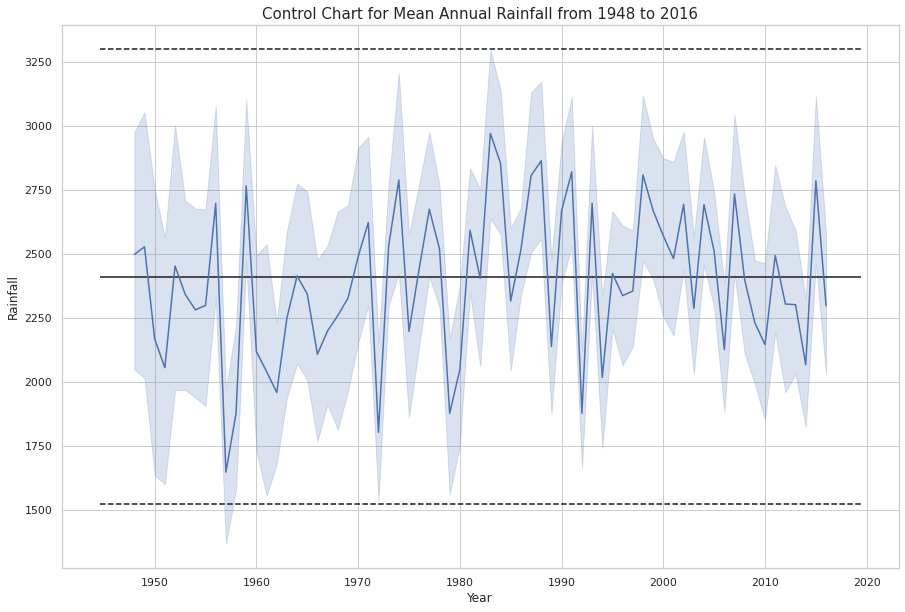

In [ ]:
plt.figure(figsize=(15,10))
ax= sns.lineplot(data= stationdf.reset_index(), x='Year', y='Rainfall')
men = stationdf.reset_index()['Rainfall'].mean()
std_dev = stationdf.std()
xmin, xmax = ax.get_xlim()
ax.hlines(men, xmin, xmax ,label='mean' )
ax.hlines([men+std_dev, men-std_dev], xmin, xmax ,linestyles='dashed',label=['mean+*std','mean-*std'] )
ax.set_title('Control Chart for Mean Annual Rainfall from 1948 to 2016', fontsize=15);
# ax= sns.lineplot(data= finaldf, x='Date', y='Rainfall')

## Model and prediction
First I will try to fit a linear model to see how far a linear model can get us. I will be using R here because its better at simple and interpretable models.

In [ ]:
X_feature, y_value = finaldf.drop(columns=['Rainfall']), finaldf['Rainfall']

train, test = train_test_split(finaldf, random_state=0)

In [ ]:
%%R -i train
r_train <- train
print(head(r_train))

           Station Year Month Day       Date Rainfall
486717 Cox's Bazar 2003    11  24 2003-11-24        0
235993    Chandpur 1982     6   5 1982-06-05        1
310365     Tangail 1988     1  10 1988-01-10        0
595104   Srimangal 2011     8  29 2011-08-29       14
181264     Jessore 1976     8   3 1976-08-03        2
200468   Madaripur 1978     3   4 1978-03-04        0


In [ ]:
%%R
fit1 <- lm(Rainfall ~ factor(Month) + factor(Station), data= r_train)


In [ ]:
%%R
summary(fit1)


Call:
lm(formula = Rainfall ~ factor(Month) + factor(Station), data = r_train)

Residuals:
   Min     1Q Median     3Q    Max 
-21.34  -7.28  -2.22   0.68 571.37 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 1.775915   0.269678   6.585 4.54e-11 ***
factor(Month)2              0.433127   0.127495   3.397 0.000681 ***
factor(Month)3              1.146531   0.124430   9.214  < 2e-16 ***
factor(Month)4              3.366322   0.125268  26.873  < 2e-16 ***
factor(Month)5              8.223316   0.124287  66.164  < 2e-16 ***
factor(Month)6             15.023098   0.125357 119.843  < 2e-16 ***
factor(Month)7             16.476899   0.124284 132.574  < 2e-16 ***
factor(Month)8             12.888082   0.124265 103.714  < 2e-16 ***
factor(Month)9             10.255099   0.125283  81.856  < 2e-16 ***
factor(Month)10             5.492508   0.124239  44.209  < 2e-16 ***
factor(Month)11             0.928093   0.125179   7.414 1.23e-

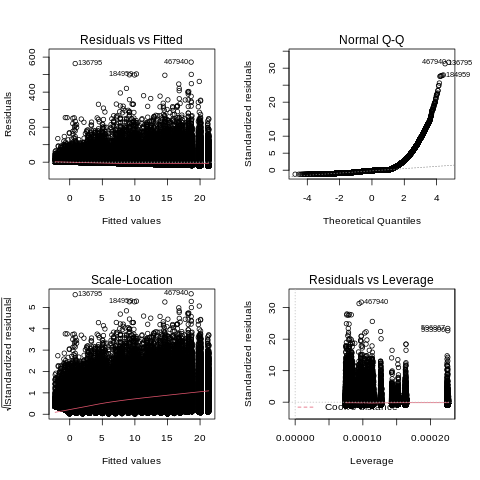

In [ ]:
%%R
par(mfrow=c(2,2))
plot(fit1)

In [ ]:
%%R
fit2 <- update(fit1, Rainfall ~ factor(Month) + factor(Station)+ factor(Month)*factor(Station))

In [ ]:
%%R
summary(fit2)


Call:
lm(formula = Rainfall ~ factor(Month) + factor(Station) + factor(Month):factor(Station), 
    data = r_train)

Residuals:
   Min     1Q Median     3Q    Max 
-34.03  -6.77  -1.32  -0.25 567.22 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                  0.237209   0.860355   0.276
factor(Month)2                               0.084127   1.248374   0.067
factor(Month)3                               0.817683   1.224685   0.668
factor(Month)4                               2.806048   1.245034   2.254
factor(Month)5                              10.367107   1.226172   8.455
factor(Month)6                              23.404734   1.246697  18.773
factor(Month)7                              21.725581   1.216725  17.856
factor(Month)8                              15.102692   1.234576  12.233
factor(Month)9                               9.978672   1.236937   8.067
factor(Month)10                              7.649810 

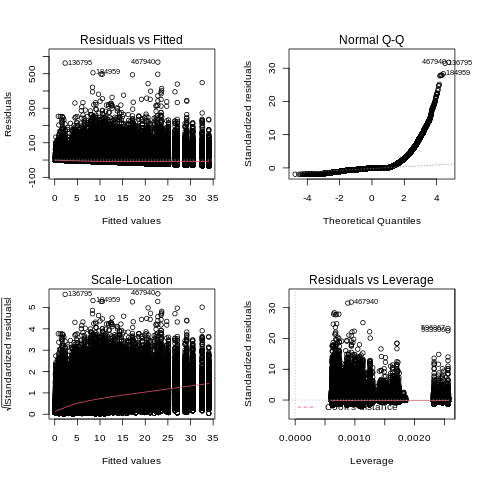

In [ ]:
%%R
par(mfrow=c(2,2))
plot(fit2)

In [ ]:
%%R
fit3 <- update(fit1, Rainfall ~ factor(Month) + factor(Station) + factor(Day)+ factor(Month)*factor(Station) + factor(Month)*factor(Day))

In [ ]:
%%R
summary(fit3)$ fit3$


Call:
lm(formula = Rainfall ~ factor(Month) + factor(Station) + factor(Day) + 
    factor(Month):factor(Station) + factor(Month):factor(Day), 
    data = r_train)

Residuals:
   Min     1Q Median     3Q    Max 
-36.93  -6.82  -1.29  -0.15 565.61 

Coefficients: (6 not defined because of singularities)
                                             Estimate Std. Error t value
(Intercept)                                  0.029498   0.979160   0.030
factor(Month)2                               0.108407   1.414332   0.077
factor(Month)3                               0.540001   1.389974   0.388
factor(Month)4                               3.010377   1.409293   2.136
factor(Month)5                               7.897691   1.391729   5.675
factor(Month)6                              18.892502   1.410422  13.395
factor(Month)7                              24.583616   1.385163  17.748
factor(Month)8                              16.559044   1.401353  11.816
factor(Month)9                         

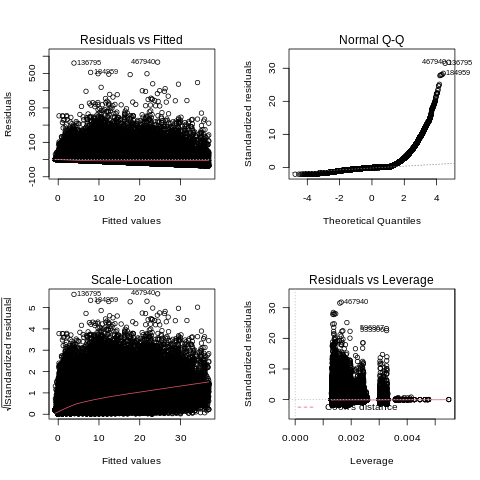

In [ ]:
%%R
par(mfrow=c(2,2))
plot(fit3)

In [ ]:
%%R
anova(fit1, fit2, fit3)

Analysis of Variance Table

Model 1: Rainfall ~ factor(Month) + factor(Station)
Model 2: Rainfall ~ factor(Month) + factor(Station) + factor(Month):factor(Station)
Model 3: Rainfall ~ factor(Month) + factor(Station) + factor(Day) + factor(Month):factor(Station) + 
    factor(Month):factor(Day)
  Res.Df       RSS  Df Sum of Sq       F    Pr(>F)    
1 495429 160502590                                    
2 495055 157571274 374   2931316 24.7792 < 2.2e-16 ***
3 494701 156475738 354   1095536  9.7841 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R -i test -o r_predictions
r_test = test
r_predictions = predict(fit3, newdata=r_test, interval='none')

### Neural network predictions

I will try to use a neural network to make deep learning model, that will hopefully make better predictions and have better R_square value.

In [39]:
# Get new response
finaldf['RainOrNot'] = np.where(finaldf['Rainfall'] > 0, 1, 0 )
finaldf

,Station,Year,Month,Day,Date,Rainfall,RainOrNot
0,Bogra,1948,2,1,1948-02-01,0.0,0
1,Bogra,1948,2,2,1948-02-02,0.0,0
2,Bogra,1948,2,3,1948-02-03,0.0,0
3,Bogra,1948,2,4,1948-02-04,4.0,1
4,Bogra,1948,2,5,1948-02-05,1.0,1
...,...,...,...,...,...,...,...
660629,Teknaf,2016,12,27,2016-12-27,0.0,0
660630,Teknaf,2016,12,28,2016-12-28,0.0,0
660631,Teknaf,2016,12,29,2016-12-29,0.0,0
660632,Teknaf,2016,12,30,2016-12-30,0.0,0


In [ ]:
# finaldf = finaldf.drop(columns=['RainOrNot'])
# finaldf

,Station,Year,Month,Day,Rainfall
0,Bogra,1948,2,1,0.0
1,Bogra,1948,2,2,0.0
2,Bogra,1948,2,3,0.0
3,Bogra,1948,2,4,4.0
4,Bogra,1948,2,5,1.0
...,...,...,...,...,...
660629,Teknaf,2016,12,27,0.0
660630,Teknaf,2016,12,28,0.0
660631,Teknaf,2016,12,29,0.0
660632,Teknaf,2016,12,30,0.0


In [40]:
# Drop un-used columns.
if 'Date' in finaldf.columns:
    finaldf = finaldf.drop(columns=['Date'])

In [41]:
train, test = train_test_split(finaldf.sample(frac=1, random_state=0), test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

422805 train examples
105702 validation examples
132127 test examples


In [42]:
# # A utility method to create a tf.data dataset from a Pandas Dataframe
# def df_to_dataset(dataframe, shuffle=True, batch_size=32):
#   dataframe = dataframe.copy()
#   labels = dataframe.pop('Rainfall')
#   ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
#   if shuffle:
#     ds = ds.shuffle(buffer_size=len(dataframe))
#   ds = ds.batch(batch_size)
#   ds = ds.prefetch(batch_size)
#   return ds

# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe[['RainOrNot','Rainfall']]
  dataframe = dataframe.drop(columns=['RainOrNot','Rainfall'])
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), dict(labels)))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
# [(train_features, label_batch)] = train_ds.take(1)
# print('Every feature:', list(train_features.keys()))
# print('A batch of stations:', train_features['Station'])
# print('A batch of targets:', label_batch )

Every feature: ['Station', 'Year', 'Month', 'Day']
A batch of stations: tf.Tensor([b'Sylhet' b'Barisal' b'Bogra' b"Cox's Bazar" b'Khepupara'], shape=(5,), dtype=string)
A batch of targets: tf.Tensor([ 6.  0.  0. 69.  3.], shape=(5,), dtype=float64)


In [43]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [ ]:
# photo_count_col = train_features['Year']
# layer = get_normalization_layer('Year', train_ds)
# layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.20791502],
       [-1.7276956 ],
       [ 1.3661435 ],
       [ 0.5519753 ],
       [-1.6191399 ]], dtype=float32)>

In [44]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Prepare a Dataset that only yields our feature.
  feature_ds = feature_ds.map(index)

  # Learn the space of possible indices.
  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [ ]:
# type_col = train_features['Station']
# layer = get_category_encoding_layer('Station', train_ds, 'string')
# layer(type_col)

<tf.Tensor: shape=(5, 37), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# type_col = train_features['Month']
# category_encoding_layer = get_category_encoding_layer('Month', train_ds,
#                                                       'int64', 5)
# category_encoding_layer(type_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [45]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [46]:
all_inputs = []
encoded_features = []


# Numeric features.
# for header in ['PhotoAmt', 'Fee']:
numeric_col = tf.keras.Input(shape=(1,), name='Year')
normalization_layer = get_normalization_layer('Year', train_ds)
encoded_numeric_col = normalization_layer(numeric_col)
all_inputs.append(numeric_col)
encoded_features.append(encoded_numeric_col)


# Categorical features encoded as string.
# int_cat_cols = 
station_col = tf.keras.Input(shape=(1,), name='Station', dtype='string')
encoding_layer = get_category_encoding_layer('Station', train_ds, dtype='string',
                                             max_tokens=5)
encoded_station_col = encoding_layer(station_col)
all_inputs.append(station_col)
encoded_features.append(encoded_station_col)

In [47]:
# Categorical features encoded as integers.
int_cat_cols = ['Month','Day']
for header in int_cat_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int64',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [48]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.L2())(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.8)(x)

x1 = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.L2())(x)
x1 = tf.keras.layers.BatchNormalization()(x1)

x1 = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L2())(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)

output1 = tf.keras.layers.Dense(1, activation='sigmoid', name='RainOrNot', trainable=False)(x1)

x2 = tf.keras.layers.concatenate([x, output1])

x2 = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.L2())(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L2())(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)

output2 = tf.keras.layers.Dense(1, activation='relu', name='Rainfall')(x2)
model = tf.keras.Model(inputs=all_inputs, outputs=[output1,output2])
model.compile(optimizer='adam',
              loss={'RainOrNot':tf.keras.losses.BinaryCrossentropy(),'Rainfall':tf.keras.losses.MeanAbsoluteError()},
              metrics={'RainOrNot':["accuracy"],'Rainfall':['mae']})
# [output1,output2]
# {'RainOrNot':tf.keras.losses.BinaryCrossentropy(),'Rainfall':tf.keras.losses.MeanAbsoluteError()}
# {'RainOrNot':["accuracy"],'Rainfall':['mae']}

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Station (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Day (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Year (InputLayer)               [(None, 1)]          0                                            
______________________________________________________________________________________________

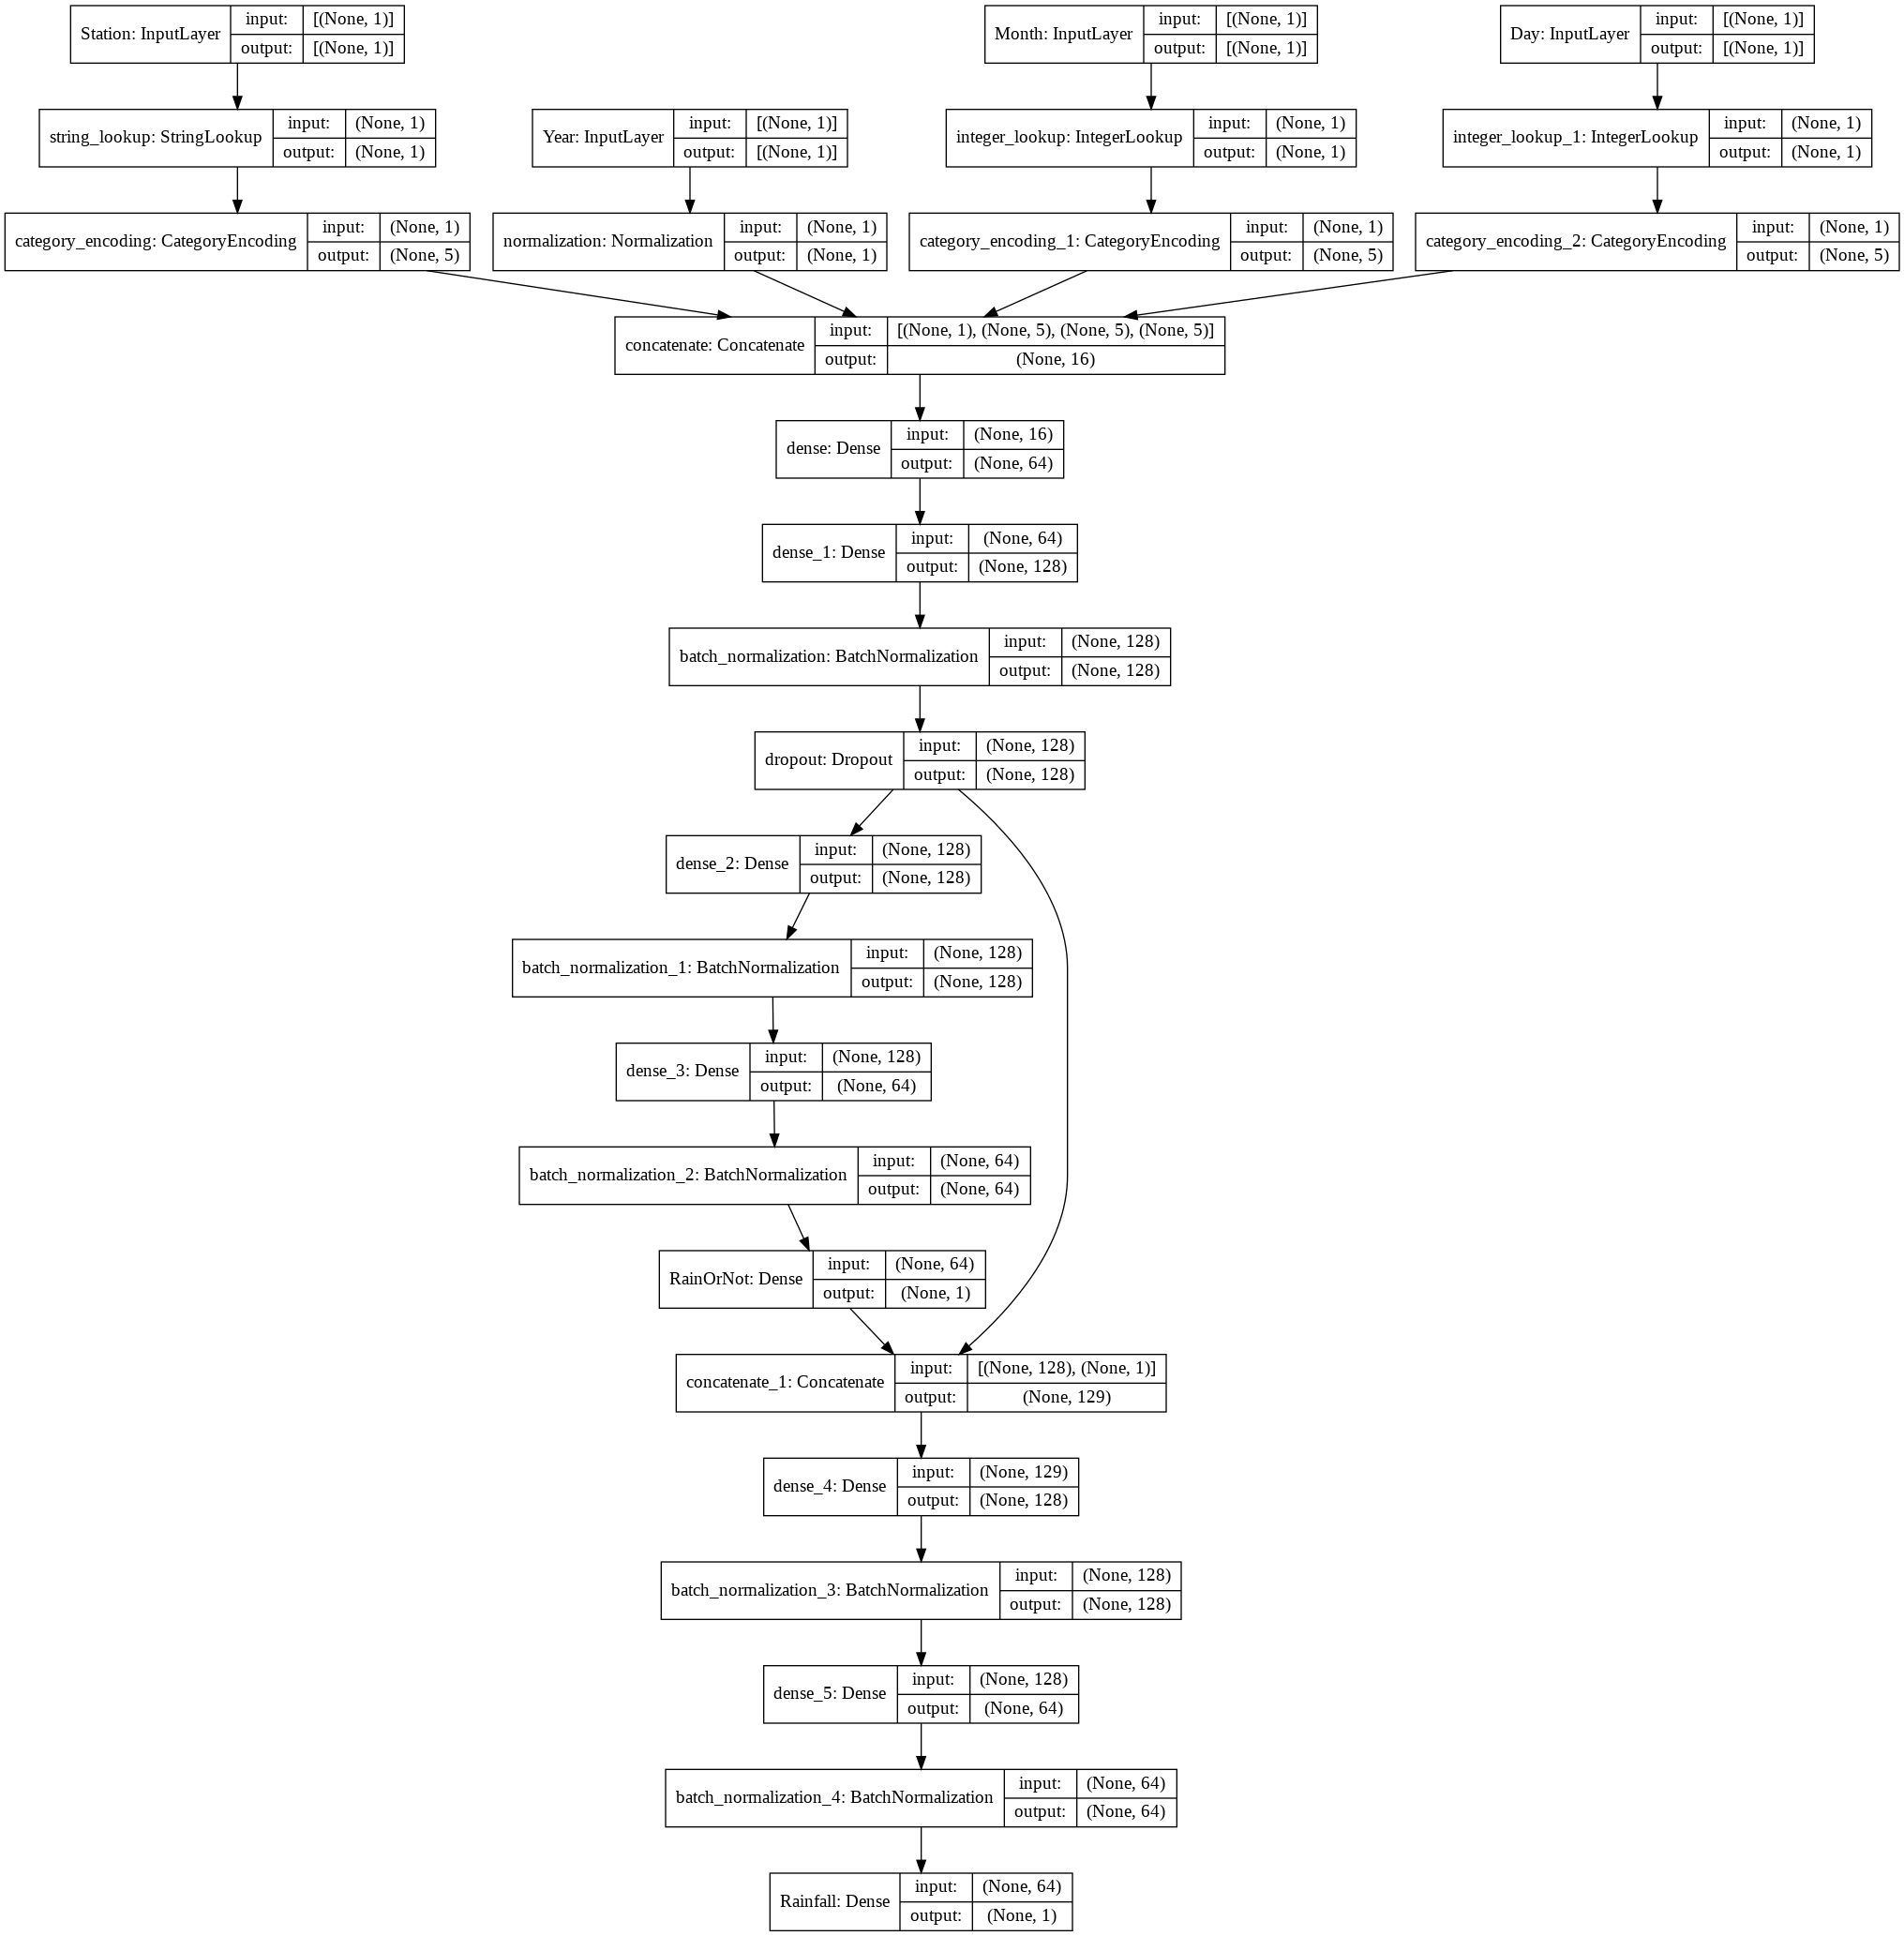

In [50]:
tf.keras.utils.plot_model(
    model, show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [51]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
1652/1652 [==============================] - 20s 10ms/step - loss: 8.4210 - RainOrNot_loss: 0.5907 - Rainfall_loss: 6.4011 - RainOrNot_accuracy: 0.7280 - Rainfall_mae: 6.4011 - val_loss: 6.9051 - val_RainOrNot_loss: 0.5566 - val_Rainfall_loss: 6.3143 - val_RainOrNot_accuracy: 0.7550 - val_Rainfall_mae: 6.3143
Epoch 2/20
1652/1652 [==============================] - 17s 10ms/step - loss: 6.9385 - RainOrNot_loss: 0.5566 - Rainfall_loss: 6.3508 - RainOrNot_accuracy: 0.7540 - Rainfall_mae: 6.3508 - val_loss: 6.8999 - val_RainOrNot_loss: 0.5637 - val_Rainfall_loss: 6.3107 - val_RainOrNot_accuracy: 0.7550 - val_Rainfall_mae: 6.3107
Epoch 3/20
1652/1652 [==============================] - 17s 10ms/step - loss: 6.9135 - RainOrNot_loss: 0.5551 - Rainfall_loss: 6.3359 - RainOrNot_accuracy: 0.7558 - Rainfall_mae: 6.3359 - val_loss: 6.8923 - val_RainOrNot_loss: 0.5585 - val_Rainfall_loss: 6.3107 - val_RainOrNot_accuracy: 0.7550 - val_Rainfall_mae: 6.3107
Epoch 4/20
1652/1652 [============

Text(0.5, 1.0, 'Mean Absolute Error vs. epochs')

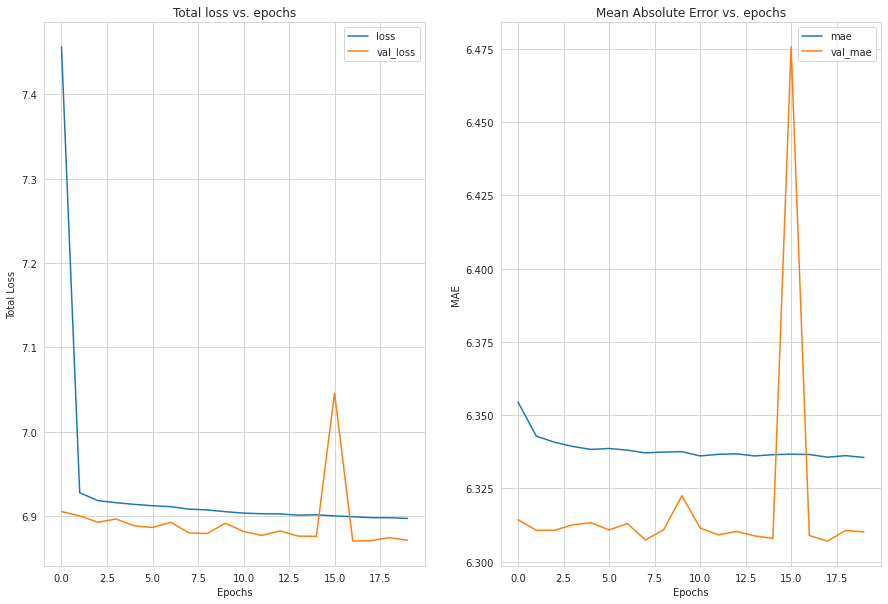

In [58]:
history.history.keys()
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].plot(history.epoch, history.history['loss'], )
ax[0].plot(history.epoch, history.history['val_loss'])
ax[0].legend(labels=['loss', 'val_loss'])

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Total Loss')
ax[0].set_title('Total loss vs. epochs')

ax[1].plot(history.epoch, history.history['Rainfall_mae'])
ax[1].plot(history.epoch, history.history['val_Rainfall_mae'])

ax[1].legend(labels=['mae', 'val_mae'])

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('MAE')
ax[1].set_title('Mean Absolute Error vs. epochs')

In [ ]:
r_predictions

array([ 5.71564312,  0.35132083, 23.89577743, ...,  0.11330106,
       10.94433808,  9.30440107])

In [ ]:
r2_score(test['Rainfall'], r_predictions)

0.12986227040678378

In [ ]:
tf_predictions = model.predict(test_ds)

In [ ]:
r2_score(test['Rainfall'] ,tf_predictions[:,0])

-0.1167879689650404

As we can see here that the R_square didn't improve much in the MLP compared to the linear model predicted by R. There is obviously lot of inherent variability in Rainfall, and using Month, Day, Station and Year as predictors aren't enough to explain the total variability. We need more accurate predictors to make get predictions about the rainfall.